In [1]:
import torch
import cv2
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

sys.path.append(os.path.join(globals()['_dh'][0], '../pyunet/lib'))
from unet import UNet

device = 'cpu'
in_channels = 3
out_channels = 4


model_normalized = UNet(
    in_channels=in_channels,
    out_channels=out_channels,
    is_normalized=True
).to(device)

model = UNet(
    in_channels=in_channels,
    out_channels=out_channels,
    is_normalized=False
).to(device)

## Load the Model

In [8]:
model_file = "/home/ralampay/workspace/pyunet/models/covid19ctscan-256.pth"
model_file_normalized = "/home/ralampay/workspace/pyunet/models/covid19ctscan-256-normalized.pth"

state_normalized = torch.load(model_file_normalized, map_location=device)
model_normalized.load_state_dict(state_normalized['state_dict'])

state = torch.load(model_file, map_location=device)
model.load_state_dict(state['state_dict'])

<All keys matched successfully>

## Load the Input and Mask Image

Ground Truth Labels:
[0 1 2]
Prediction Labels:
[0 1 2 3]
Normalized Prediction Labels:
[0 1 2 3]


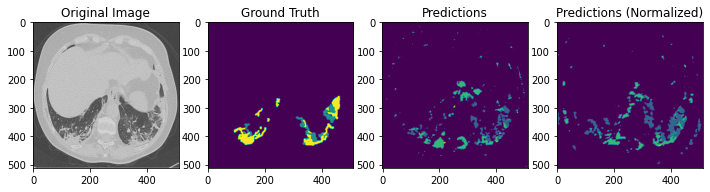

In [9]:
img_file = "/home/ralampay/Pictures/covid19ctscan/training/images/scan_slice36.png"
mask_file = "/home/ralampay/Pictures/covid19ctscan/training/masks/scan_slice36.tiff"

img_width = 256
img_height = 256
dim = (img_width, img_height)

img = cv2.imread(img_file, 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB since OpenCV2 reads images as BGR

mask = cv2.imread(mask_file, 0)

# Build img as a tensor
# x should be in list to be fed in forward method
# Transpose to 2,0,1 for input to model
x = torch.Tensor(
    np.array([img.transpose((2, 0, 1))])
).to(device)

# Map predictions back to original orientation
# Squeeze axis=2 to get single prediction
predictions = np.squeeze(
    torch.argmax(
        model.forward(x),
        1
    ).detach().cpu().numpy().astype(np.int32).transpose(
        (1, 2, 0)
    ), axis=2
)

predictions_normalized = np.squeeze(
    torch.argmax(
        model_normalized.forward(x),
        1
    ).detach().cpu().numpy().astype(np.int32).transpose(
        (1, 2, 0)
    ), axis=2
)

print("Ground Truth Labels:")
print(np.unique(mask.ravel()))

print("Prediction Labels:")
print(np.unique(predictions.ravel()))

print("Normalized Prediction Labels:")
print(np.unique(predictions_normalized.ravel()))

plt.figure(figsize=(12, 8))
plt.subplot(141)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(142)
plt.imshow(mask)
plt.title("Ground Truth")
plt.subplot(143)
plt.imshow(predictions)
plt.title("Predictions")
plt.subplot(144)
plt.imshow(predictions_normalized)
plt.title("Predictions (Normalized)")
plt.show()

## Compute Intersection Over Union

In [7]:
from sklearn.metrics import jaccard_score

macro_score = jaccard_score(mask.ravel(), predictions.ravel(), average='macro')
label_score = jaccard_score(mask.ravel(), predictions.ravel(), average=None)

macro_score_normalized = jaccard_score(mask.ravel(), predictions_normalized.ravel(), average='macro')
label_score_normalized = jaccard_score(mask.ravel(), predictions_normalized.ravel(), average=None)

print("Model:")
print("Macro Score: {}".format(macro_score))
print("Label Score: {}".format(label_score))

print("Model (Normalized):")
print("Macro Score: {}".format(macro_score_normalized))
print("Label Score: {}".format(label_score_normalized))

Model:
Macro Score: 0.3612998971031979
Label Score: [0.96643659 0.151244   0.327519   0.        ]
Model (Normalized):
Macro Score: 0.4122388694961998
Label Score: [0.97538149 0.17136898 0.3557082  0.14649682]
